# SIAMESE NETWORKS

TABLE OF CONTENTS

INTRODUCTION

SERUP

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt



## HELPER FUNCTIONS

## LOAD AND PREPROCESSING DATA

In [46]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.


print(x_train.shape, x_test.shape)

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


x_train.shape, x_test.shape


(60000, 28, 28) (10000, 28, 28)


((60000, 28, 28, 1), (10000, 28, 28, 1))

We will generate pairs of images to train a model to recognize similarity. Each pair will consist of two images:

- If both images show the same digit, the pair is considered a positive pair and labeled with a 1.

- If the images show different digits, the pair is a negative pair and labeled with a 0.

In [49]:
# Function to create pairs (positive and negative)
def create_pairs(x, y):
    pairs = []
    labels = []
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    for d in range(num_classes):
        for i in range(len(digit_indices[d]) - 1):
            # Positive pair
            idx1, idx2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs.append([x[idx1], x[idx2]])
            labels.append(1)

            # Negative pair
            neg_class = (d + 1) % num_classes
            idx1 = digit_indices[d][i]
            idx2 = np.random.choice(digit_indices[neg_class])
            pairs.append([x[idx1], x[idx2]])
            labels.append(0)
    return np.array(pairs), np.array(labels).astype("float32")

pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

print("Pairs train shape:", pairs_train.shape)
print("Labels train shape:", labels_train.shape)

Pairs train shape: (119980, 2, 28, 28, 1)
Labels train shape: (119980,)


We can see that, for training, we have 1,198,980 pairs of images as features, where each image has a shape of 28×28×1.


In [50]:
import matplotlib.pyplot as plt

def plot_image_pairs(pairs, labels, num_pairs=5):
    """
    Plots `num_pairs` image pairs with their labels.
    Each pair is shown side-by-side with the label on top.
    """
    plt.figure(figsize=(num_pairs * 2.5, 3))
    
    for i in range(num_pairs):
        pair = pairs[i]
        label = int(labels[i])
        
        # First image
        ax = plt.subplot(2, num_pairs, i + 1) # Top row: first image of pair
        plt.imshow(pair[0].squeeze(), cmap="gray")
        plt.axis("off")
        ax.set_title(f"Label: {label}")
        
        # Second image
        ax = plt.subplot(2, num_pairs, i + 1 + num_pairs) # Bottom row: second image of pair
        plt.imshow(pair[1].squeeze(), cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


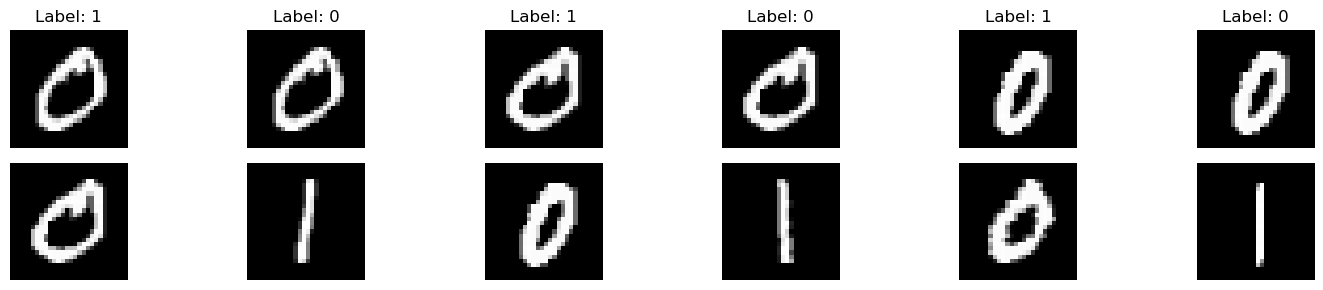

In [99]:
plot_image_pairs(pairs_train, labels_train, num_pairs=6)


## loss fn (contrastive loss)

The goal of contrastive loss is to bring similar instances closer together in the embedding space and push apart dissimilar instances.

Contrastive loss is used to learn embeddings such that similar pairs are pulled closer and dissimilar pairs are pushed apart in the embedding space.

**Contrastive Loss**

Given two embeddings **x₁** and **x₂**, and a label **y**:

- y = 1 if they are similar
- y = 0 if they are dissimilar

The loss is defined as:

$$
L = y \cdot D^2 + (1 - y) \cdot \max(0, m - D)^2
$$

where:

$$
D = \| x_1 - x_2 \|_2  $$ is the Euclidean distance between the embeddings.


m is a margin that defines how far apart dissimilar pairs should be





In [55]:
# Contrastive loss (assumimg y_pred is the distance D ||x1 -x2||2, noma 2)
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

compute euclidean distance

In [54]:
# Compute Euclidean distance between embeddings
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, 1e-10))

## Model

We will build the following network:



...........DAW.................



In [56]:
# Define the base network (simple CNN)
def base_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu")(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    return Model(input, x)

input_shape = x_train.shape[1:]
base_net = base_network(input_shape)

# Define inputs
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

# Get embeddings
processed_a = base_net(input_a)
processed_b = base_net(input_b)


distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])

# Define the Siamese model
model = Model([input_a, input_b], distance)


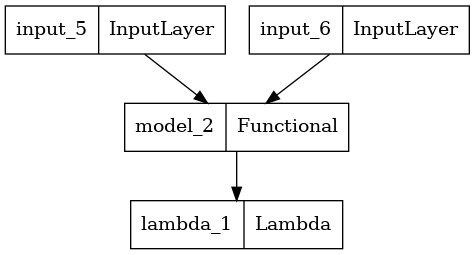

In [57]:
tf.keras.utils.plot_model(model)

In [63]:
# Compile
model.compile(loss=contrastive_loss, optimizer="adam", metrics=["accuracy"])

In [64]:
# Prepare data for training
pair_1 = pairs_train[:, 0]  # all first images in the pairs
pair_2 = pairs_train[:, 1]  # all second images in the pairs

pair_1_test = pairs_test[:, 0]
pair_2_test = pairs_test[:, 1]

pair_1[i] and pair_2[i] give you the two images forming the i-th pair.

In [65]:
# Train
history = model.fit(
    [pair_1, pair_2], labels_train,
    validation_data=([pair_1_test, pair_2_test], labels_test),
    batch_size=128,
    epochs=8
)

2025-05-26 17:57:35.916403: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376257280 exceeds 10% of free system memory.


Epoch 1/8


2025-05-26 17:57:36.481507: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376257280 exceeds 10% of free system memory.


938/938 [==============================] - 77s 81ms/step - loss: 0.0354 - accuracy: 0.0251 - val_loss: 0.0196 - val_accuracy: 0.0114
Epoch 2/8
938/938 [==============================] - 75s 80ms/step - loss: 0.0176 - accuracy: 0.0096 - val_loss: 0.0165 - val_accuracy: 0.0107
Epoch 3/8
938/938 [==============================] - 73s 78ms/step - loss: 0.0143 - accuracy: 0.0071 - val_loss: 0.0151 - val_accuracy: 0.0094
Epoch 4/8
938/938 [==============================] - 73s 78ms/step - loss: 0.0124 - accuracy: 0.0052 - val_loss: 0.0154 - val_accuracy: 0.0088
Epoch 5/8
938/938 [==============================] - 72s 77ms/step - loss: 0.0113 - accuracy: 0.0043 - val_loss: 0.0154 - val_accuracy: 0.0091
Epoch 6/8
938/938 [==============================] - 77s 82ms/step - loss: 0.0102 - accuracy: 0.0035 - val_loss: 0.0147 - val_accuracy: 0.0095
Epoch 7/8
938/938 [==============================] - 72s 76ms/step - loss: 0.0094 - accuracy: 0.0028 - val_loss: 0.0138 - val_accuracy: 0.0090
Epoch 8/8

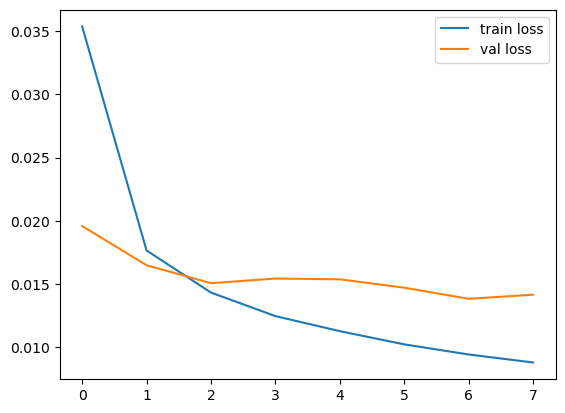

In [66]:
# Plot loss curve
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [89]:
# making preds
# evaluation

In [93]:
#pred = model.predict([pair_1_test[7], pair_2_test[7]])
img1 = np.expand_dims(pair_1_test[7], axis=0)  # shape: (1, 28, 28, 1)
img2 = np.expand_dims(pair_2_test[7], axis=0)
pred = model.predict([img1, img2])
pred # is the euclidean distance


1/1 [==============================] - 0s 20ms/step


array([[1.2554563]], dtype=float32)

In [92]:
def plot_pair(img1, img2, true_label=None, prediction=None):
    plt.figure(figsize=(4, 2))

    # First image
    ax1 = plt.subplot(1, 2, 1)
    plt.imshow(img1.squeeze(), cmap="gray")
    plt.axis("off")
    ax1.set_title("Image 1")

    # Second image
    ax2 = plt.subplot(1, 2, 2)
    plt.imshow(img2.squeeze(), cmap="gray")
    plt.axis("off")
    title = "Image 2"
    if true_label is not None:
        title += f"\nTrue: {true_label}"
    if prediction is not None:
        title += f"\nPred: {prediction:.2f}"
    ax2.set_title(title)

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 19ms/step


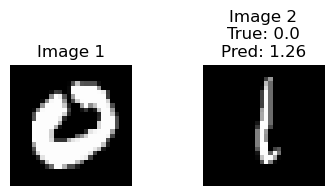

In [94]:
i = 7
img1 = pair_1_test[i]
img2 = pair_2_test[i]
true_label = labels_test[i]

# Add batch dimension for prediction
pred = model.predict([np.expand_dims(img1, 0), np.expand_dims(img2, 0)]).item()

plot_pair(img1, img2, true_label, pred)


In [87]:
def plot_image_pairs_with_predictions(pairs, true_labels, predictions, num_pairs=5):
    """
    Plots image pairs with their predicted similarity and true label.
    - `pairs`: list/array of image pairs [(img1, img2), ...]
    - `true_labels`: list/array of 0 or 1 labels
    - `predictions`: model predictions (probabilities or distances)
    """
    plt.figure(figsize=(num_pairs * 3, 4))
    
    for i in range(num_pairs):
        pair = pairs[i]
        true_label = int(true_labels[i])
        pred = predictions[i]
        
        # First image
        ax = plt.subplot(2, num_pairs, i + 1)
        plt.imshow(pair[0].squeeze(), cmap="gray")
        plt.axis("off")
        ax.set_title(f"True: {true_label}, Distance: {pred.item():.2f}")
        
        # Second image
        ax = plt.subplot(2, num_pairs, i + 1 + num_pairs)
        plt.imshow(pair[1].squeeze(), cmap="gray")
        plt.axis("off")
        #ax.set_title(f"Pred: {pred.item():.2f}")


    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 23ms/step


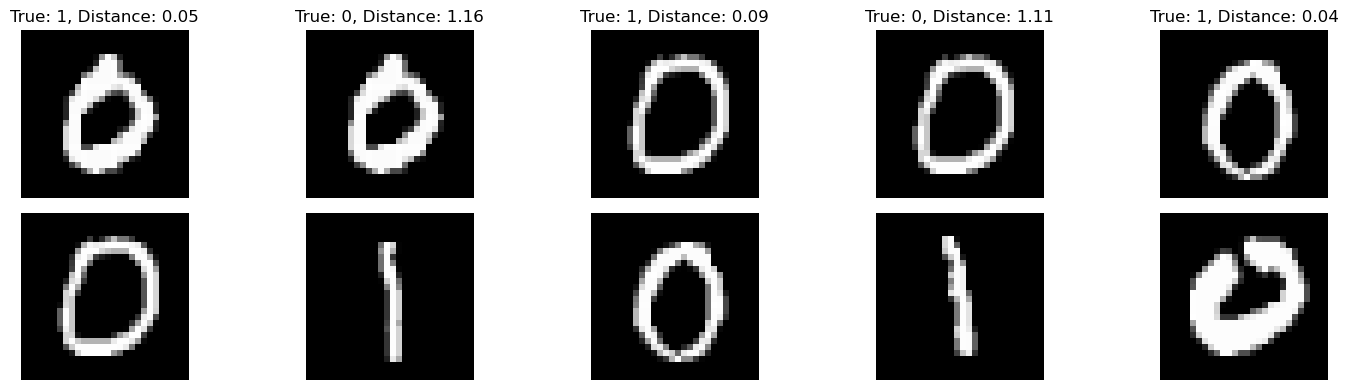

In [88]:
preds = model.predict([pair_1_test[:10], pair_2_test[:10]])
plot_image_pairs_with_predictions(pairs_test, labels_test, preds)


## evaluation

In [95]:
distances = model.predict([pair_1_test, pair_2_test]).squeeze()  # shape: (N,)


625/625 [==============================] - 4s 6ms/step


In [96]:
threshold = 1.0  # you can tune this
binary_preds = (distances < threshold).astype(int)


In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = labels_test

print("Accuracy:", accuracy_score(y_true, binary_preds))
print("Precision:", precision_score(y_true, binary_preds))
print("Recall:", recall_score(y_true, binary_preds))
print("F1 Score:", f1_score(y_true, binary_preds))
print("Confusion Matrix:\n", confusion_matrix(y_true, binary_preds))


Accuracy: 0.867067067067067
Precision: 0.7901107594936709
Recall: 0.9996996996996997
F1 Score: 0.8826336721166593
Confusion Matrix:
 [[7337 2653]
 [   3 9987]]


In [100]:
# Tune threshold
import numpy as np

best_thresh = 0
best_f1 = 0

for t in np.linspace(0.1, 2.0, 50):
    preds = (distances < t).astype(int)
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh:.2f}, Best F1: {best_f1:.2f}")


Best threshold: 0.60, Best F1: 0.99


Your confusion matrix is 2×2 because your labels are binary:

1 means "same" (the two images belong to the same class)

0 means "different" (the two images belong to different classes)

In [ ]:
# embedded visualization